In [30]:
import os
import glob

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import ray

In [31]:
LuftFileList = glob.glob("../DATA/MWIS_2023_NDJF_OBS/*MARWIS*csv")
VaisalaFileList = glob.glob("../DATA/MWIS_2023_NDJF_OBS/*move4*csv")

In [39]:
luft_total_list = []
for luft in LuftFileList:
    luft_df = pd.read_csv(luft, low_memory=False)
    luft_total_list.append(luft_df)
luft_total_df = pd.concat(luft_total_list)

vi_total_list = []
for vi in VaisalaFileList:
    vi_df = pd.read_csv(vi, low_memory=False)
    vi_total_list.append(vi_df)
vi_total_df = pd.concat(vi_total_list)

drop_column_list = ['gdirection1','gdirection2','digitalcomp_x','digitalcomp_y','digitalcomp_z',
                    'ta2','rh2','loggerta', 'batteryvolt', 'rev1', 'rev2']
vi_total_df.drop(drop_column_list, axis = 1, inplace=True)

# Extract components of the date and time
year = vi_total_df['gdate'].astype(str).str[-6:-4].apply(lambda x: '20' + x if len(x) == 2 else x)  # Handling two-digit year
month = vi_total_df['gdate'].astype(str).str[-4:-2]
day = vi_total_df['gdate'].astype(str).str[-2:]

hour = vi_total_df['gtime'].astype(str).str[-6:-4].str.zfill(2)
minute = vi_total_df['gtime'].astype(str).str[-4:-2]
second = vi_total_df['gtime'].astype(str).str[-2:]

# Combine extracted components into a datetime string and convert to datetime
vi_total_df['TIMESTAMP'] = pd.to_datetime(
    year + '-' + month + '-' + day + ' ' + hour + ':' + minute + ':' + second,
    format='%Y-%m-%d %H:%M:%S'
)

vi_total_df['TIMESTAMP'] = pd.to_datetime(vi_total_df['TIMESTAMP'])
luft_total_df['TIMESTAMP'] = pd.to_datetime(luft_total_df['TIMESTAMP'])

In [40]:
total_df = pd.merge(vi_total_df, luft_total_df, on='TIMESTAMP', how='outer', suffixes=('_vi', '_luft'))

In [42]:
total_df.to_csv("../DATA/CONCAT/luft_vi_2023_2024.csv", index=None)

In [43]:
total_df[['TIMESTAMP','glatitude', 'glongitude', 'galtitude','vsp', 'rws', 'rwd', 'tws', 'twd', 'ta1', 'rh1', 'pressure',
       'precipitation', 'raindetector', 'solarradiation', 'sw_down', 'sw_up','lw_down', 'lw_up', 'netradiation', 's_ta', 's_status', 'grip',
       'waterlayer', 'icelayer', 'snowlayer', 'R_Tem', 'R_Dew', 'R_Hum', 'R_WH', 'R_Sta', 'R_Ice', 'R_Fric','R_Sta_txt']].corr()

Index(['vehicle', 'gdate', 'gtime', 'glatitude', 'glongitude', 'galtitude',
       'vsp', 'rws', 'rwd', 'tws', 'twd', 'ta1', 'rh1', 'pressure',
       'precipitation', 'raindetector', 'solarradiation', 'sw_down', 'sw_up',
       'lw_down', 'lw_up', 'netradiation', 's_ta', 's_status', 'grip',
       'waterlayer', 'icelayer', 'snowlayer', 'TIMESTAMP', 'YYMMDD', 'HHMMSS',
       'R_Tem', 'R_Dew', 'R_Hum', 'R_WH', 'R_Sta', 'R_Ice', 'R_Fric',
       'R_Sta_txt', 'BattV', 'PTemp'],
      dtype='object')

In [59]:
# Replace '//////' with NaN in the specified columns
columns_to_replace = ['glatitude', 'glongitude', 'galtitude', 'vsp', 'rws', 'rwd', 'tws', 'twd', 
                      'ta1', 'rh1', 'pressure', 'precipitation', 'raindetector', 'solarradiation', 
                      'sw_down', 'sw_up', 'lw_down', 'lw_up', 'netradiation', 's_ta', 's_status', 
                      'grip', 'waterlayer', 'icelayer', 'snowlayer', 'R_Tem', 'R_Dew', 'R_Hum', 
                      'R_WH', 'R_Sta', 'R_Ice', 'R_Fric', 'R_Sta_txt']

total_df[columns_to_replace] = total_df[columns_to_replace].replace('//////', np.nan)
total_df[columns_to_replace] = total_df[columns_to_replace].replace('/', np.nan)
total_df[columns_to_replace] = total_df[columns_to_replace].replace('////', np.nan)
total_df[columns_to_replace] = total_df[columns_to_replace].replace('///////', np.nan)

<Axes: >

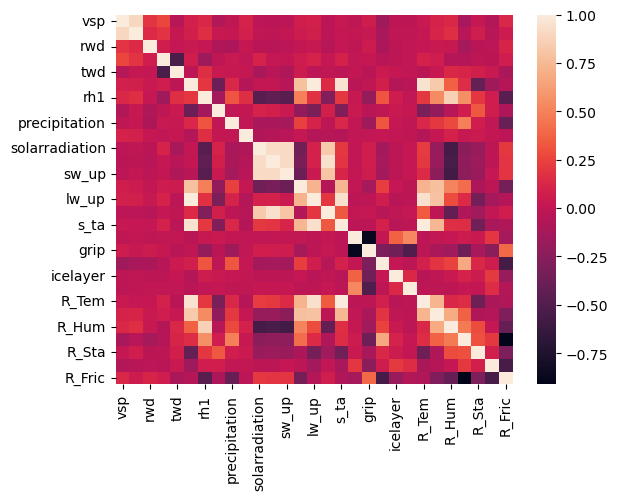

In [63]:
sns.heatmap(total_df[['vsp', 'rws', 'rwd', 'tws', 'twd', 'ta1', 'rh1', 'pressure',
       'precipitation', 'raindetector', 'solarradiation', 'sw_down', 'sw_up','lw_down', 'lw_up', 'netradiation', 's_ta', 's_status', 'grip',
       'waterlayer', 'icelayer', 'snowlayer', 'R_Tem', 'R_Dew', 'R_Hum', 'R_WH', 'R_Sta', 'R_Ice', 'R_Fric']].corr())

In [73]:
total_df['s_status'].unique()

array(['1', nan, '2', '102', '206', '3', '101', '106', '6', '7', '201',
       '103', '9', '202', '207', '107', '203'], dtype=object)

In [75]:
total_df['R_Sta'].unique()

array([ 5.,  1.,  2.,  0.,  3.,  6.,  4., nan])

In [33]:
# luft_total_df.to_csv("../DATA/CONCAT/luft_2023_2024.csv", index=None)
# vi_total_df.to_csv("../DATA/CONCAT/visala_2023_2024.csv", index=None)